### Bước 1: Cài đặt các thư viện cần thiết

In [26]:
!pip install tensorflow
!pip install split-folders
!pip install albumentations
!pip install tqdm
!pip install opencv-python-headless
!pip install torch torchvision torchaudio

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
import datetime
import platform

### Bước 2: Đặt đường dẫn home chứa folder project hiện tại

In [27]:
import platform

if platform.system() == 'Linux':
    home_dir = '/content/drive/MyDrive/ClassificationofMangoDiseases'
elif platform.system() == 'Windows':
    home_dir = 'D:\Projects\ClassificationofMangoDiseases'
else:
    raise ValueError('Unsupported platform')

print(f'Home directory: {home_dir}')

Home directory: D:\Projects\ClassificationofMangoDiseases


### Bước 3: Kết nối với Google Drive nếu đang chạy trên Google Colab

In [28]:
if platform.system() == 'Linux':
    from google.colab import drive
    drive.mount('/content/drive')

### Bước 4: Đặt đường dẫn tới tập dữ liệu

In [29]:
# Đường dẫn tới tập dữ liệu đã chọn (gốc hoặc đã remove background)
data_dir = os.path.join(home_dir, 'data/MangoFruitDDS/SenMangoFruitDDS_bgremoved')  # Hoặc 'SenMangoFruitDDS_original'
output_dir = os.path.join(home_dir, 'data/processed')

print(f'Data directory: {data_dir}')
print(f'Output directory: {output_dir}')

Data directory: D:\Projects\ClassificationofMangoDiseases\data/MangoFruitDDS/SenMangoFruitDDS_bgremoved
Output directory: D:\Projects\ClassificationofMangoDiseases\data/processed


### Bước 5: Tiền xử lý dữ liệu và phân chia tập dữ liệu

Sử dụng thư viện `split-folders` để phân chia tập dữ liệu thành các tập `train`, `valid`, và `test`.

In [30]:
# Xóa thư mục đầu ra nếu đã tồn tại
if os.path.exists(output_dir):
    import shutil
    shutil.rmtree(output_dir)

# Phân chia dữ liệu
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(.7, .2, .1), group_prefix=None)

### Bước 6: Hiển thị thông tin thư mục sau khi phân chia

In [31]:
# Kiểm tra các thư mục sau khi phân chia
for root, dirs, files in os.walk(output_dir):
    level = root.replace(output_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print('{}{}'.format(subindent, f))

processed/
    test/
        Alternaria/
            Alternaria_011.jpg
            Alternaria_012.jpg
            Alternaria_013.jpg
            Alternaria_027.jpg
            Alternaria_028.jpg
            Alternaria_031.jpg
            Alternaria_033.jpg
            Alternaria_040.jpg
            Alternaria_060.jpg
            Alternaria_062.jpg
            Alternaria_064.jpg
            Alternaria_067.jpg
            Alternaria_075.jpg
            Alternaria_113.jpg
            Alternaria_144.jpg
            Alternaria_156.jpg
            Alternaria_168.jpg
        Anthracnose/
            Anthracnose_008.jpg
            Anthracnose_013.jpg
            Anthracnose_015.jpg
            Anthracnose_019.jpg
            Anthracnose_030.jpg
            Anthracnose_033.jpg
            Anthracnose_037.jpg
            Anthracnose_071.jpg
            Anthracnose_088.jpg
            Anthracnose_096.jpg
            Anthracnose_116.jpg
            Anthracnose_123.jpg
            Anthracnose_128

### Bước 7: Xác nhận kết quả

Kiểm tra lại thư mục đã được phân chia đúng cách.

Classes: ['Alternaria', 'Anthracnose', 'Black Mould Rot', 'Healthy', 'Stem and Rot']
Random class: Stem and Rot
Random image path: D:\Projects\ClassificationofMangoDiseases\data/processed\train\Stem and Rot\Lasiodiplodia_141.jpg


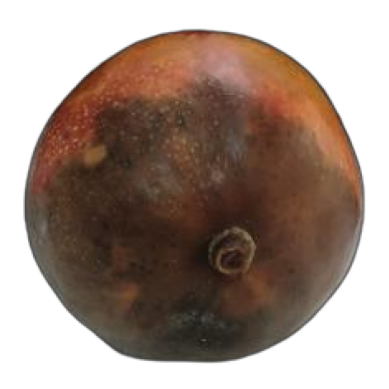

In [32]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Hiển thị một số hình ảnh từ tập train
train_dir = os.path.join(output_dir, 'train')
class_names = os.listdir(train_dir)
print(f'Classes: {class_names}')

# Chọn ngẫu nhiên một lớp
random_class = random.choice(class_names)
print(f'Random class: {random_class}')

# Chọn ngẫu nhiên một hình ảnh từ lớp đó
random_image_path = os.path.join(train_dir, random_class, random.choice(os.listdir(os.path.join(train_dir, random_class))))
print(f'Random image path: {random_image_path}')

# Hiển thị hình ảnh
image = Image.open(random_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

### Bước 8: Thực hiện tăng cường dữ liệu

In [33]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2

# Định nghĩa các phép tăng cường dữ liệu
augmentations = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
        A.GaussNoise(),
        A.MultiplicativeNoise()
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
])

# Tạo thư mục đầu ra cho dữ liệu tăng cường
augmented_dir = os.path.join(home_dir, 'data/augmented')
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Áp dụng tăng cường dữ liệu
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)
    if not os.path.exists(augmented_class_dir):
        os.makedirs(augmented_class_dir)
    for img_name in tqdm(os.listdir(class_dir)):
        img_path = os.path.join(class_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = augmentations(image=image)
        augmented_image = augmented['image']
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
        augmented_img_name = f'aug_{img_name}'
        cv2.imwrite(os.path.join(augmented_class_dir, augmented_img_name), augmented_image)

c:\Users\Minh Dua\.conda\envs\mangoddsenv\lib\site-packages\albumentations\core\validation.py:45: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)
100%|██████████| 109/109 [00:02<00:00, 37.84it/s]


### Bước 9: Xây dựng các mô hình và huấn luyện

In [34]:
import numpy as np
import tensorflow as tf
import random
import os

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define common hyperparameters
batch_size = 32
epochs = 1
learning_rate = 0.001

# Define common loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define image size and input shape
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Function to create a simple CNN model
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Function to create a ResNet model
def create_resnet_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Function to create an Inception model
def create_inception_model(input_shape, num_classes):
    base_model = tf.keras.applications.InceptionV3(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Function to create a DenseNet model
def create_densenet_model(input_shape, num_classes):
    base_model = tf.keras.applications.DenseNet121(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Function to create a model using Transfer Learning
def create_transfer_learning_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG16(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Example usage:
num_classes = len(class_names)  # Adjust this according to your dataset
cnn_model = create_cnn_model(input_shape, num_classes)
resnet_model = create_resnet_model(input_shape, num_classes)
inception_model = create_inception_model(input_shape, num_classes)
densenet_model = create_densenet_model(input_shape, num_classes)
transfer_learning_model = create_transfer_learning_model(input_shape, num_classes)

# Compile the models
models = [cnn_model, resnet_model, inception_model, densenet_model, transfer_learning_model]
for model in models:
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### Bước 10: Huấn luyện và lưu mô hình

In [40]:
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
def get_model_save_path(model_name, augmented=False):
    suffix = 'Aug' if augmented else 'Ori'
    model_name_with_suffix = f"{model_name}{suffix}"
    
    if platform.system() == 'Linux':
        base_path = f'/content/drive/MyDrive/ClassificationofMangoDiseases/models/{model_name_with_suffix}/{date_time}'
    elif platform.system() == 'Windows':
        base_path = f'D:\\Projects\\ClassificationofMangoDiseases\\models\\{model_name_with_suffix}\\{date_time}'
    else:
        raise ValueError('Unsupported platform')
    
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    return base_path

def create_optimizer():
    return tf.keras.optimizers.Adam(learning_rate=learning_rate)

def plot_history(history, model_name, augmented=False):
    base_path = get_model_save_path(model_name, augmented)
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(base_path, 'accuracy.png'))
    plt.close()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(base_path, 'loss.png'))
    plt.close()

def save_classification_report(y_true, y_pred, class_names, base_path):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(os.path.join(base_path, 'classification_report.csv'), index=True)

def save_confusion_matrix(y_true, y_pred, class_names, base_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(base_path, 'confusion_matrix.png'))
    plt.close()

def save_roc_curve(y_true, y_score, base_path, num_classes):
    # Binarize the output
    y_true_binarized = label_binarize(y_true, classes=[i for i in range(num_classes)])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(base_path, 'roc_curve.png'))
    plt.close()

def save_precision_recall_curve(y_true, y_score, base_path, num_classes):
    y_true_binarized = label_binarize(y_true, classes=[i for i in range(num_classes)])
    
    precision = dict()
    recall = dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label='Class {0}'.format(i))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(base_path, 'precision_recall_curve.png'))
    plt.close()

def evaluate_model(model, valid_generator, model_name, augmented=False):
    base_path = get_model_save_path(model_name, augmented)
    y_true = valid_generator.classes
    y_pred = model.predict(valid_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    save_classification_report(y_true, y_pred_classes, class_names, base_path)
    save_confusion_matrix(y_true, y_pred_classes, class_names, base_path)
    save_roc_curve(y_true, y_pred, base_path, num_classes=len(class_names))
    save_precision_recall_curve(y_true, y_pred, base_path, num_classes=len(class_names))

# Training data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

original_models = {
    'CNNCustomOri': cnn_model,
    'ResNet50Ori': resnet_model,
    'InceptionV3Ori': inception_model,
    'DenseNet121Ori': densenet_model,
    'VGG16Ori': transfer_learning_model
}

for model_name, model in original_models.items():
    model.compile(optimizer=create_optimizer(), loss=loss_function, metrics=['accuracy'])
    base_path = get_model_save_path(model_name)
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs)
    model.save(os.path.join(base_path, 'model.h5'))
    plot_history(history, model_name)
    evaluate_model(model, valid_generator, model_name)

augmented_train_dir = os.path.join(home_dir, 'data/augmented')
train_generator_aug = train_datagen.flow_from_directory(
    augmented_train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

augmented_models = {
    'CNNCustomAug': create_cnn_model(input_shape, num_classes),
    'ResNet50Aug': create_resnet_model(input_shape, num_classes),
    'InceptionV3Aug': create_inception_model(input_shape, num_classes),
    'DenseNet121Aug': create_densenet_model(input_shape, num_classes),
    'VGG16Aug': create_transfer_learning_model(input_shape, num_classes)
}

for model_name, model in augmented_models.items():
    model.compile(optimizer=create_optimizer(), loss=loss_function, metrics=['accuracy'])
    base_path = get_model_save_path(model_name, augmented=True)
    history = model.fit(train_generator_aug, validation_data=valid_generator, epochs=epochs)
    model.save(os.path.join(base_path, 'model.h5'))
    plot_history(history, model_name, augmented=True)
    evaluate_model(model, valid_generator, model_name, augmented=True)


Found 584 images belonging to 5 classes.
Found 166 images belonging to 5 classes.


c:\Users\Minh Dua\.conda\envs\mangoddsenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.7417 - loss: 0.6199 - val_accuracy: 0.6807 - val_loss: 0.8619


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.1840 - loss: 1.7943 - val_accuracy: 0.2470 - val_loss: 1.6246


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step


c:\Users\Minh Dua\.conda\envs\mangoddsenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Minh Dua\.conda\envs\mangoddsenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Minh Dua\.conda\envs\mangoddsenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

19/19 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.6356 - loss: 1.0451 - val_accuracy: 0.7169 - val_loss: 0.7147


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.7149 - loss: 0.7793 - val_accuracy: 0.7651 - val_loss: 0.7198


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 781s 43s/step - accuracy: 0.5277 - loss: 1.2020 - val_accuracy: 0.5904 - val_loss: 1.0371


4/6 ━━━━━━━━━━━━━━━━━━━━ 1:07 34s/step